In [218]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import pandas as pd
import scipy
from scipy.optimize import minimize

import pickle
import ipywidgets as widgets


In [173]:
from modules.utils import to_latex_table

In [144]:
with open('..//data//women_hours_empirical', 'rb') as f:
    women_hours = pickle.load(f)
    
with open('..//data//men_hours_empirical', 'rb') as f:
    men_hours = pickle.load(f)
    
with open('..//data//women_salary_mean.pkl', 'rb') as f:
    women_salary = pickle.load(f)
    
with open('..//data//men_salary_mean.pkl', 'rb') as f:
    men_salary = pickle.load(f)
    
with open('..//data//fertility.pkl', 'rb') as f:
    fertility = pickle.load(f)

In [212]:
class SalaryProcess:
    
    S_min = 120
    PARAMETERS = {
        'sigma_epsilon'  : 0.15,
        'alpha' :1.2,
        'eta_G'  : 1.2,
        'eta_Z'  : 1.2,
        'eta_G_sq': 0.1,
        'delta'  : 0.9,
    }
    
    def __init__(self, Z=0, G=2, Q=18, sex='women', parameters = PARAMETERS):
        self.Z = Z
        self.G = G
        self.Q = Q
        self.sex = sex
        self.parameters = parameters
        self.Z_hist = list()
        
    def reset(self):
        self.Q = 18
        self.G = 2
        self.Z = 0
        
        # temp
        self.Z_hist.append(self.Z)

        
    def step(self):
        
        H = self.H() 
        if self.Q == 70:
            self.reset()
            H = self.H() 
            
        else:
            
            self.Q = self.Q + 1
            H = self.H() 

            self.G = self.parameters['delta'] * self.G + H / 37
            self.Z = self.Z + np.random.normal(0, self.parameters['sigma_epsilon'])
            
            # temp
            self.Z_hist.append(self.Z)
            
        S = self.calc_salary()
        return (S, self.Z, self.G, self.Q, H)
            
    def H(self):
        if self.sex=='women':
            if 18 < self.Q < 43:
                p = fertility[self.Q]
                dummy = np.random.binomial(1, p)
                if dummy == 1:
                    return 0.0
        
            return women_hours[self.Q]
        
        elif self.sex=='men':
            return men_hours[self.Q]
        else:
            raise Exception('sex must be either "women" or "men"')
        
    def calc_salary(self):
        log_S_tilde = self.parameters['alpha'] + self.parameters['eta_G'] * self.G + self.parameters['eta_G_sq'] * self.G**2 
        
        
        S_tilde = np.exp(log_S_tilde)
        S = np.max([S_tilde + self.Z, self.S_min])
        if pd.isnull(S):
            print(S_tilde, log_S_tilde, S)
        return S

In [231]:
def plot_salary_process(delta=0.9, alpha=2.3, sigma_epsilon=0.00001, eta_G=0.8, eta_G_sq= 0.1, sex='women'):
    parameters = {
        'delta': delta,
        'alpha': alpha,
        'sigma_epsilon': sigma_epsilon,
        'eta_G': eta_G,
        'eta_G_sq': eta_G_sq,
    }
    
    sp = SalaryProcess(parameters = parameters, sex=sex)
    results = list()

    for _ in range((70-18) * 500):
    
        res = sp.step()
        results.append(res)
        
    df = pd.DataFrame(results, columns = ['S', 'log Z', 'G', 'Q', 'H'])
    
    hours_pred = np.array(df.groupby('Q').mean()['H'])

    y_pred = np.array(df.groupby('Q').mean()['S'])
    y_pred_90 = np.array(df.groupby('Q').quantile(0.90)['S'])
    y_pred_75 = np.array(df.groupby('Q').quantile(0.75)['S'])
    y_pred_25 = np.array(df.groupby('Q').quantile(0.25)['S'])
    y_pred_10= np.array(df.groupby('Q').quantile(0.10)['S'])
    
    y_pred = y_pred[0:66-18]
    y_pred_90 = y_pred_90[0:66-18]
    y_pred_75 = y_pred_75[0:66-18]
    y_pred_25 = y_pred_25[0:66-18]
    y_pred_10 = y_pred_10[0:66-18]

    
    size_const = 0.6
    f, ax = plt.subplots(1,1, figsize=(size_const*14, size_const*8))
    ax.plot(range(18,66),y_pred, label=f'predicted {sex}')
    ax.fill_between(range(18,66), y_pred_90, y_pred_10, color='C0', alpha=0.25)
    ax.fill_between(range(18,66), y_pred_75, y_pred_25, color='C0', alpha=0.25)


    if sex == 'women':
        ax.plot(range(18,66), women_salary[18:66], label=f'true {sex}')
        
    if sex == 'men':
        ax.plot(range(18,66), men_salary[18:66], label=f'true {sex}')
        
    ax.set_title(f'Simulated wage path for {sex}')
    ax.set_ylabel('wage DKK')
    ax.set_xlabel('age')
    
    ax.axvline(60, color='black', ls='--', label='tuning end')
    
    ax.legend()

    
    return sp, df, f

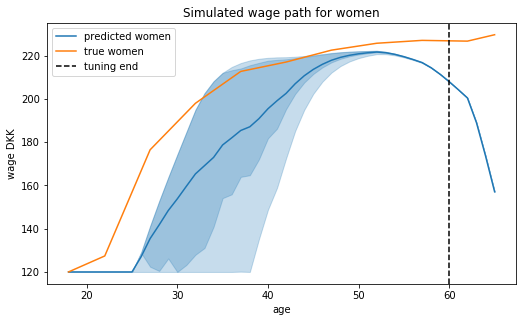

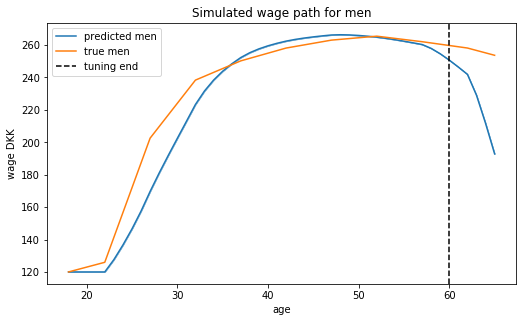

In [234]:

women_hours_, w_df, f_women = plot_salary_process(alpha=4, delta=0.7, eta_G=0.15, eta_G_sq=0.1, sex='women')
men_hours_, m_df, f_men = plot_salary_process(alpha=4, delta=0.7, eta_G=0.15,  eta_G_sq=0.1, sex='men')

In [122]:
def calc_mse(y_pred, sex='women'):
    
    
    ly_pred = len(y_pred)
    if sex == 'women':
        y_true = women_salary[18:18 + ly_pred ]
    elif sex == 'men':
        y_true = men_salary[18:18 + ly_pred ]
    else:
        raise Exception('sex must be men or women')
    
    y_pred = np.array(y_pred)
    
    ly_true = len(y_true) 
    
    ly_pred = len(y_pred)
    
    assert ly_true == ly_pred, print(ly_true, ly_pred)
    
    mse = np.mean((y_true - y_pred)**2)

    return mse
    

def obj(x):
    
    np.random.seed(100)
    
    parameters = {
        'alpha' : x[0],
        'eta_G'  : x[1],
        'eta_G_sq': x[2],
        'delta'  : x[3],
    }
    
    
    # women result
    sp = SalaryProcess(parameters = parameters)
    results = list()

    for _ in range((70-18) * 500):
    
        res = sp.step()
        results.append(res)
        
    
    df = pd.DataFrame(results, columns = ['S', 'log Z', 'G', 'Q', 'H'])
    df = df.loc[df['Q'] < 61]
    y_pred = np.array(df.groupby('Q').mean()['S'])
    mse_women = calc_mse(y_pred, 'women')
    
    # men result
    sp = SalaryProcess(parameters = parameters, sex='men')
    results = list()

    for _ in range((70-18) * 500):
    
        res = sp.step()
        results.append(res)
        
    
    df = pd.DataFrame(results, columns = ['S', 'log Z', 'G', 'Q', 'H'])
    df = df.loc[df['Q'] < 61]
    y_pred = np.array(df.groupby('Q').mean()['S'])
    mse_men = calc_mse(y_pred, 'men')
    
    mse = (mse_men + mse_women)/2
    parameters['mse'] = mse
    
    try:
        print(f'men: {mse_men:.1f}, women: {mse_women:.1f}', parameters)
    except:
        print(y_pred)
    
    return mse

In [125]:
x0 = [4, 0.15, 0.1, 0.7]
sol = minimize(obj, x0, options={'maxiter':100})


men: 143.2, women: 503.9 {'alpha': 4.0, 'eta_G': 0.15, 'eta_G_sq': 0.1, 'delta': 0.7, 'mse': 323.5353471805039}
men: 143.2, women: 503.9 {'alpha': 4.000000014901161, 'eta_G': 0.15, 'eta_G_sq': 0.1, 'delta': 0.7, 'mse': 323.53529708632834}
men: 143.2, women: 503.9 {'alpha': 4.0, 'eta_G': 0.1500000149011612, 'eta_G_sq': 0.1, 'delta': 0.7, 'mse': 323.53520769158956}
men: 143.2, women: 503.9 {'alpha': 4.0, 'eta_G': 0.15, 'eta_G_sq': 0.1000000149011612, 'delta': 0.7, 'mse': 323.5349560545976}
men: 143.2, women: 503.9 {'alpha': 4.0, 'eta_G': 0.15, 'eta_G_sq': 0.1, 'delta': 0.7000000149011611, 'mse': 323.53504798772406}
men: 143.2, women: 503.9 {'alpha': 4.0, 'eta_G': 0.15, 'eta_G_sq': 0.1, 'delta': 0.7, 'mse': 323.5353471805039}


/Users/jeppejohansen/.local/share/virtualenvs/speciale-wQK9LG7Y/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: overflow encountered in exp
/Users/jeppejohansen/.local/share/virtualenvs/speciale-wQK9LG7Y/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in square


men: inf, women: inf {'alpha': 4.098384494381736, 'eta_G': 0.4239549290442791, 'eta_G_sq': 0.8681676383897502, 'delta': 1.2876118339927372, 'mse': inf}
men: inf, women: inf {'alpha': 4.098384494381736, 'eta_G': 0.4239549290442791, 'eta_G_sq': 0.8681676383897502, 'delta': 1.2876118339927372, 'mse': inf}
men: inf, women: inf {'alpha': 4.098384509282897, 'eta_G': 0.4239549290442791, 'eta_G_sq': 0.8681676383897502, 'delta': 1.2876118339927372, 'mse': inf}
men: inf, women: inf {'alpha': 4.098384494381736, 'eta_G': 0.4239549439454403, 'eta_G_sq': 0.8681676383897502, 'delta': 1.2876118339927372, 'mse': inf}
men: inf, women: inf {'alpha': 4.098384494381736, 'eta_G': 0.4239549290442791, 'eta_G_sq': 0.8681676532909114, 'delta': 1.2876118339927372, 'mse': inf}
men: inf, women: inf {'alpha': 4.098384494381736, 'eta_G': 0.4239549290442791, 'eta_G_sq': 0.8681676383897502, 'delta': 1.2876118488938983, 'mse': inf}
men: 143.2, women: 503.9 {'alpha': 4.0, 'eta_G': 0.15, 'eta_G_sq': 0.1, 'delta': 0.7, 'm

/Users/jeppejohansen/.local/share/virtualenvs/speciale-wQK9LG7Y/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: overflow encountered in exp
/Users/jeppejohansen/.local/share/virtualenvs/speciale-wQK9LG7Y/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in square


men: inf, women: inf {'alpha': 4.098384494381736, 'eta_G': 0.4239549290442791, 'eta_G_sq': 0.8681676383897502, 'delta': 1.2876118339927372, 'mse': inf}
men: inf, women: inf {'alpha': 4.049192247190868, 'eta_G': 0.28697746452213957, 'eta_G_sq': 0.4840838191948751, 'delta': 0.9938059169963686, 'mse': inf}
men: 502312007713410.3, women: 9875565533552.6 {'alpha': 4.024596123595434, 'eta_G': 0.2184887322610698, 'eta_G_sq': 0.2920419095974376, 'delta': 0.8469029584981842, 'mse': 256093786623481.47}
men: 12916534.2, women: 3054149.6 {'alpha': 4.012298061797717, 'eta_G': 0.18424436613053488, 'eta_G_sq': 0.19602095479871878, 'delta': 0.7734514792490921, 'mse': 7985341.928050458}
men: 735845.9, women: 226550.6 {'alpha': 4.00819870684246, 'eta_G': 0.17282957457265788, 'eta_G_sq': 0.164013961880886, 'delta': 0.7489676467246377, 'mse': 481198.2191216392}
men: 89896.8, women: 29571.3 {'alpha': 4.005036838574483, 'eta_G': 0.16402524618286066, 'eta_G_sq': 0.13932668879405918, 'delta': 0.73008305293305

men: 77.7, women: 257.9 {'alpha': 4.0686862876975125, 'eta_G': 0.21508407035086433, 'eta_G_sq': 0.07172862986337795, 'delta': 0.7057919867775267, 'mse': 167.7936324195502}
men: 77.7, women: 257.9 {'alpha': 4.0686862876975125, 'eta_G': 0.21508407035086433, 'eta_G_sq': 0.07172861496221676, 'delta': 0.7057920016786879, 'mse': 167.79364289229136}
men: 61.6, women: 268.0 {'alpha': 4.081756992498345, 'eta_G': 0.22363969467643036, 'eta_G_sq': 0.06065468725834148, 'delta': 0.7145725046242486, 'mse': 164.8235884242143}
men: 61.6, women: 268.0 {'alpha': 4.081756992498345, 'eta_G': 0.22363969467643036, 'eta_G_sq': 0.06065468725834148, 'delta': 0.7145725046242486, 'mse': 164.8235884242143}
men: 61.6, women: 268.0 {'alpha': 4.081757007399506, 'eta_G': 0.22363969467643036, 'eta_G_sq': 0.06065468725834148, 'delta': 0.7145725046242486, 'mse': 164.82356110232075}
men: 61.6, women: 268.0 {'alpha': 4.081756992498345, 'eta_G': 0.22363970957759155, 'eta_G_sq': 0.06065468725834148, 'delta': 0.71457250462424

men: 74.7, women: 109.7 {'alpha': 4.608554178728767, 'eta_G': -0.035809582581187854, 'eta_G_sq': 0.11002560460692541, 'delta': 0.6849424757573614, 'mse': 92.2145277767158}
men: 74.7, women: 109.7 {'alpha': 4.608554178728767, 'eta_G': -0.035809582581187854, 'eta_G_sq': 0.11002558970576422, 'delta': 0.6849424906585226, 'mse': 92.21452286987044}
men: 62.6, women: 114.3 {'alpha': 4.474678351383191, 'eta_G': 0.06211917065937919, 'eta_G_sq': 0.08944569885269409, 'delta': 0.6888871102259694, 'mse': 88.41916654616536}
men: 62.6, women: 114.3 {'alpha': 4.474678351383191, 'eta_G': 0.06211917065937919, 'eta_G_sq': 0.08944569885269409, 'delta': 0.6888871102259694, 'mse': 88.41916654616536}
men: 62.6, women: 114.3 {'alpha': 4.474678366284352, 'eta_G': 0.06211917065937919, 'eta_G_sq': 0.08944569885269409, 'delta': 0.6888871102259694, 'mse': 88.41915987861375}
men: 62.6, women: 114.3 {'alpha': 4.474678351383191, 'eta_G': 0.062119185560540385, 'eta_G_sq': 0.08944569885269409, 'delta': 0.68888711022596

men: 34.1, women: 109.5 {'alpha': 3.3001197567652754, 'eta_G': 0.9658091741800816, 'eta_G_sq': -0.08199802937171287, 'delta': 0.6931918841780493, 'mse': 71.79087557981339}
men: 34.1, women: 109.5 {'alpha': 3.3001197567652754, 'eta_G': 0.9658091741800816, 'eta_G_sq': -0.08199804427287406, 'delta': 0.6931918990792105, 'mse': 71.79087753681672}
men: 28.6, women: 112.8 {'alpha': 3.2044276567687895, 'eta_G': 1.0210016219026194, 'eta_G_sq': -0.09246281279329262, 'delta': 0.698944157753115, 'mse': 70.71153539572681}
men: 28.6, women: 112.8 {'alpha': 3.2044276567687895, 'eta_G': 1.0210016219026194, 'eta_G_sq': -0.09246281279329262, 'delta': 0.698944157753115, 'mse': 70.71153539572681}
men: 28.6, women: 112.8 {'alpha': 3.2044276716699507, 'eta_G': 1.0210016219026194, 'eta_G_sq': -0.09246281279329262, 'delta': 0.698944157753115, 'mse': 70.71153220442733}
men: 28.6, women: 112.8 {'alpha': 3.2044276567687895, 'eta_G': 1.0210016368037806, 'eta_G_sq': -0.09246281279329262, 'delta': 0.698944157753115

men: 32.4, women: 83.9 {'alpha': 3.8426499156114176, 'eta_G': 0.5341518821507084, 'eta_G_sq': -0.02603744895496274, 'delta': 0.7531335668251766, 'mse': 58.17611702786037}
men: 32.4, women: 83.9 {'alpha': 3.8426499156114176, 'eta_G': 0.5341518821507084, 'eta_G_sq': -0.026037463856123932, 'delta': 0.7531335817263378, 'mse': 58.17609635798395}
men: 44.7, women: 71.1 {'alpha': 3.942543340497738, 'eta_G': 0.4884798831934435, 'eta_G_sq': -0.02010225238054475, 'delta': 0.7501226673459483, 'mse': 57.887118016747095}
men: 44.7, women: 71.1 {'alpha': 3.942543340497738, 'eta_G': 0.4884798831934435, 'eta_G_sq': -0.02010225238054475, 'delta': 0.7501226673459483, 'mse': 57.887118016747095}
men: 44.7, women: 71.1 {'alpha': 3.9425433553988993, 'eta_G': 0.4884798831934435, 'eta_G_sq': -0.02010225238054475, 'delta': 0.7501226673459483, 'mse': 57.88711880094012}
men: 44.7, women: 71.1 {'alpha': 3.942543340497738, 'eta_G': 0.4884798980946047, 'eta_G_sq': -0.02010225238054475, 'delta': 0.7501226673459483, 

men: 40.4, women: 74.2 {'alpha': 3.9780686859644416, 'eta_G': 0.4541050084596912, 'eta_G_sq': -0.016928964742876394, 'delta': 0.7601296561102425, 'mse': 57.30271809171019}
men: 40.4, women: 74.2 {'alpha': 3.9780686859644416, 'eta_G': 0.4541050084596912, 'eta_G_sq': -0.016928979644037587, 'delta': 0.7601296710114037, 'mse': 57.30271742343609}
men: 40.6, women: 74.0 {'alpha': 3.977645770958724, 'eta_G': 0.45437921837890216, 'eta_G_sq': -0.0172022914512618, 'delta': 0.7608160562925287, 'mse': 57.29957567926724}
men: 40.6, women: 74.0 {'alpha': 3.977645770958724, 'eta_G': 0.45437921837890216, 'eta_G_sq': -0.0172022914512618, 'delta': 0.7608160562925287, 'mse': 57.29957567926724}
men: 40.6, women: 74.0 {'alpha': 3.977645785859885, 'eta_G': 0.45437921837890216, 'eta_G_sq': -0.0172022914512618, 'delta': 0.7608160562925287, 'mse': 57.299575655769715}
men: 40.6, women: 74.0 {'alpha': 3.977645770958724, 'eta_G': 0.45437923328006335, 'eta_G_sq': -0.0172022914512618, 'delta': 0.7608160562925287, '

men: 40.5, women: 74.1 {'alpha': 3.974760716169995, 'eta_G': 0.4561882148476566, 'eta_G_sq': -0.017454605781997385, 'delta': 0.7607585729278339, 'mse': 57.29928198893519}
men: 40.5, women: 74.1 {'alpha': 3.974760716169995, 'eta_G': 0.4561882148476566, 'eta_G_sq': -0.01745462068315858, 'delta': 0.7607585878289951, 'mse': 57.299281996266686}
men: 40.5, women: 74.1 {'alpha': 3.974760775373298, 'eta_G': 0.45618817605936335, 'eta_G_sq': -0.01745461493037331, 'delta': 0.7607585727631218, 'mse': 57.299281999716584}
men: 40.5, women: 74.1 {'alpha': 3.974760775373298, 'eta_G': 0.45618817605936335, 'eta_G_sq': -0.01745461493037331, 'delta': 0.7607585727631218, 'mse': 57.299281999716584}
men: 40.5, women: 74.1 {'alpha': 3.974760790274459, 'eta_G': 0.45618817605936335, 'eta_G_sq': -0.01745461493037331, 'delta': 0.7607585727631218, 'mse': 57.299281998954115}
men: 40.5, women: 74.1 {'alpha': 3.974760775373298, 'eta_G': 0.45618819096052454, 'eta_G_sq': -0.01745461493037331, 'delta': 0.760758572763121

men: 40.5, women: 74.1 {'alpha': 3.974760782281346, 'eta_G': 0.4561881715334097, 'eta_G_sq': -0.017454599357957016, 'delta': 0.7607585727439026, 'mse': 57.29928198857779}
men: 40.5, women: 74.1 {'alpha': 3.974760782281346, 'eta_G': 0.4561881715334097, 'eta_G_sq': -0.01745461425911821, 'delta': 0.7607585876450638, 'mse': 57.299281995982284}
men: 40.5, women: 74.1 {'alpha': 3.974760782281351, 'eta_G': 0.4561881715334066, 'eta_G_sq': -0.01745461425911775, 'delta': 0.7607585727439026, 'mse': 57.29928199968863}
men: 40.5, women: 74.1 {'alpha': 3.974760782281351, 'eta_G': 0.4561881715334066, 'eta_G_sq': -0.01745461425911775, 'delta': 0.7607585727439026, 'mse': 57.29928199968863}
men: 40.5, women: 74.1 {'alpha': 3.9747607971825123, 'eta_G': 0.4561881715334066, 'eta_G_sq': -0.01745461425911775, 'delta': 0.7607585727439026, 'mse': 57.29928199892697}
men: 40.5, women: 74.1 {'alpha': 3.974760782281351, 'eta_G': 0.45618818643456777, 'eta_G_sq': -0.01745461425911775, 'delta': 0.7607585727439026, 'm

men: 40.5, women: 74.1 {'alpha': 3.9747607822813475, 'eta_G': 0.4561881715334089, 'eta_G_sq': -0.017454599357956898, 'delta': 0.7607585727439026, 'mse': 57.2992819885779}
men: 40.5, women: 74.1 {'alpha': 3.9747607822813475, 'eta_G': 0.4561881715334089, 'eta_G_sq': -0.017454614259118092, 'delta': 0.7607585876450638, 'mse': 57.29928199598197}
men: 40.5, women: 74.1 {'alpha': 3.974760782281347, 'eta_G': 0.4561881715334093, 'eta_G_sq': -0.01745461425911815, 'delta': 0.7607585727439026, 'mse': 57.29928199968819}
men: 40.5, women: 74.1 {'alpha': 3.974760782281347, 'eta_G': 0.4561881715334093, 'eta_G_sq': -0.01745461425911815, 'delta': 0.7607585727439026, 'mse': 57.29928199968819}
men: 40.5, women: 74.1 {'alpha': 3.9747607971825083, 'eta_G': 0.4561881715334093, 'eta_G_sq': -0.01745461425911815, 'delta': 0.7607585727439026, 'mse': 57.299281998927235}
men: 40.5, women: 74.1 {'alpha': 3.974760782281347, 'eta_G': 0.4561881864345705, 'eta_G_sq': -0.01745461425911815, 'delta': 0.7607585727439026, '

men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.45618817153340946, 'eta_G_sq': -0.017454599357956985, 'delta': 0.7607585727439026, 'mse': 57.2992819885778}
men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.45618817153340946, 'eta_G_sq': -0.01745461425911818, 'delta': 0.7607585876450638, 'mse': 57.299281995981694}
men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.45618817153340946, 'eta_G_sq': -0.01745461425911818, 'delta': 0.7607585727439026, 'mse': 57.299281999688134}
men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.45618817153340946, 'eta_G_sq': -0.01745461425911818, 'delta': 0.7607585727439026, 'mse': 57.299281999688134}
men: 40.5, women: 74.1 {'alpha': 3.974760797182508, 'eta_G': 0.45618817153340946, 'eta_G_sq': -0.01745461425911818, 'delta': 0.7607585727439026, 'mse': 57.29928199892733}
men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.45618818643457065, 'eta_G_sq': -0.01745461425911818, 'delta': 0.7607585727

men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.4561881715334095, 'eta_G_sq': -0.017454599357956995, 'delta': 0.7607585727439026, 'mse': 57.29928198857775}
men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.4561881715334095, 'eta_G_sq': -0.01745461425911819, 'delta': 0.7607585876450638, 'mse': 57.299281995981765}
men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.4561881715334095, 'eta_G_sq': -0.01745461425911819, 'delta': 0.7607585727439026, 'mse': 57.29928199968808}
men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.4561881715334095, 'eta_G_sq': -0.01745461425911819, 'delta': 0.7607585727439026, 'mse': 57.29928199968808}
men: 40.5, women: 74.1 {'alpha': 3.974760797182508, 'eta_G': 0.4561881715334095, 'eta_G_sq': -0.01745461425911819, 'delta': 0.7607585727439026, 'mse': 57.29928199892703}
men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.4561881864345707, 'eta_G_sq': -0.01745461425911819, 'delta': 0.7607585727439026,

men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.4561881715334095, 'eta_G_sq': -0.017454599357956995, 'delta': 0.7607585727439026, 'mse': 57.29928198857775}
men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.4561881715334095, 'eta_G_sq': -0.01745461425911819, 'delta': 0.7607585876450638, 'mse': 57.299281995981765}
men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.4561881715334095, 'eta_G_sq': -0.01745461425911819, 'delta': 0.7607585727439026, 'mse': 57.29928199968808}
men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.4561881715334095, 'eta_G_sq': -0.01745461425911819, 'delta': 0.7607585727439026, 'mse': 57.29928199968808}
men: 40.5, women: 74.1 {'alpha': 3.974760797182508, 'eta_G': 0.4561881715334095, 'eta_G_sq': -0.01745461425911819, 'delta': 0.7607585727439026, 'mse': 57.29928199892703}
men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.4561881864345707, 'eta_G_sq': -0.01745461425911819, 'delta': 0.7607585727439026,

men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.4561881715334095, 'eta_G_sq': -0.017454599357956995, 'delta': 0.7607585727439026, 'mse': 57.29928198857775}
men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.4561881715334095, 'eta_G_sq': -0.01745461425911819, 'delta': 0.7607585876450638, 'mse': 57.299281995981765}
men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.4561881715334095, 'eta_G_sq': -0.01745461425911819, 'delta': 0.7607585727439026, 'mse': 57.29928199968808}
men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.4561881715334095, 'eta_G_sq': -0.01745461425911819, 'delta': 0.7607585727439026, 'mse': 57.29928199968808}
men: 40.5, women: 74.1 {'alpha': 3.974760797182508, 'eta_G': 0.4561881715334095, 'eta_G_sq': -0.01745461425911819, 'delta': 0.7607585727439026, 'mse': 57.29928199892703}
men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.4561881864345707, 'eta_G_sq': -0.01745461425911819, 'delta': 0.7607585727439026,

men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.4561881715334095, 'eta_G_sq': -0.017454599357956995, 'delta': 0.7607585727439026, 'mse': 57.29928198857775}
men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.4561881715334095, 'eta_G_sq': -0.01745461425911819, 'delta': 0.7607585876450638, 'mse': 57.299281995981765}
men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.4561881715334095, 'eta_G_sq': -0.01745461425911819, 'delta': 0.7607585727439026, 'mse': 57.29928199968808}
men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.4561881715334095, 'eta_G_sq': -0.01745461425911819, 'delta': 0.7607585727439026, 'mse': 57.29928199968808}
men: 40.5, women: 74.1 {'alpha': 3.974760797182508, 'eta_G': 0.4561881715334095, 'eta_G_sq': -0.01745461425911819, 'delta': 0.7607585727439026, 'mse': 57.29928199892703}
men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.4561881864345707, 'eta_G_sq': -0.01745461425911819, 'delta': 0.7607585727439026,

men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.4561881715334095, 'eta_G_sq': -0.017454599357956995, 'delta': 0.7607585727439026, 'mse': 57.29928198857775}
men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.4561881715334095, 'eta_G_sq': -0.01745461425911819, 'delta': 0.7607585876450638, 'mse': 57.299281995981765}
men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.4561881715334095, 'eta_G_sq': -0.01745461425911819, 'delta': 0.7607585727439026, 'mse': 57.29928199968808}
men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.4561881715334095, 'eta_G_sq': -0.01745461425911819, 'delta': 0.7607585727439026, 'mse': 57.29928199968808}
men: 40.5, women: 74.1 {'alpha': 3.974760797182508, 'eta_G': 0.4561881715334095, 'eta_G_sq': -0.01745461425911819, 'delta': 0.7607585727439026, 'mse': 57.29928199892703}
men: 40.5, women: 74.1 {'alpha': 3.9747607822813467, 'eta_G': 0.4561881864345707, 'eta_G_sq': -0.01745461425911819, 'delta': 0.7607585727439026,

In [126]:
sol
print(sol)

old_sol5 = {'alpha': 3.7401736198159052, 'eta_G': 0.5487673463960259, 'eta_G_sq': -0.04484104545216317, 'delta': 0.8462938422559253, 'mse': 2.843191841160111}

      fun: 57.29928199968863
 hess_inv: array([[ 1.37095531e-02, -8.88831610e-03,  1.17466652e-03,
         5.97485230e-04],
       [-8.88831610e-03,  5.87438351e-03, -7.73648911e-04,
        -4.38573593e-04],
       [ 1.17466652e-03, -7.73648911e-04,  1.10429556e-04,
         3.10245727e-05],
       [ 5.97485230e-04, -4.38573593e-04,  3.10245727e-05,
         1.27862539e-04]])
      jac: array([-0.05111408, -0.19486332, -0.7456255 , -0.24876785])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 722
      nit: 36
     njev: 117
   status: 2
  success: False
        x: array([ 3.97476078,  0.45618817, -0.01745461,  0.76075857])


In [160]:
sol_dict = {
    'alpha': sol.x[0],
    'eta_G': sol.x[1],
    'eta_G_sq': sol.x[2],
    'delta': sol.x[3]
}
sol.x

array([ 3.97476078,  0.45618817, -0.01745461,  0.76075857])

In [174]:
def change_name(name):
    
    if name == 'eta_G_sq':
        name = 'eta_{G^{2}}'

    return '$\\' + name + '$'

parameter_hat = pd.DataFrame([{change_name(key) : value for key, value in sol_dict.items()}])

In [195]:
to_latex_table('..//tables//wage_path_parameters_solved', parameter_hat, nr_decimals=3)

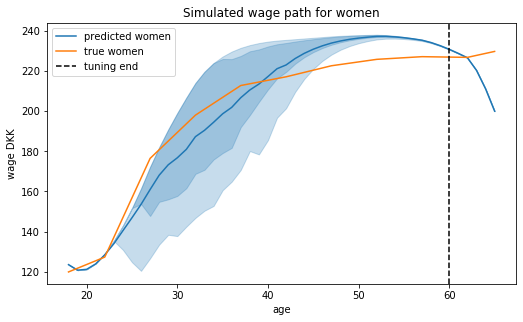

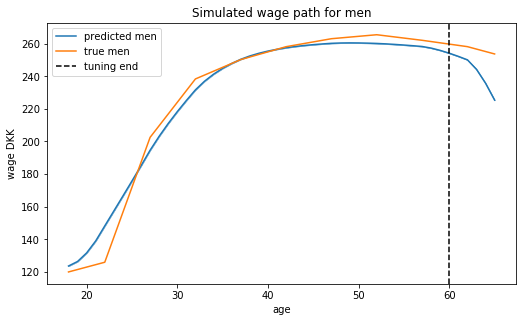

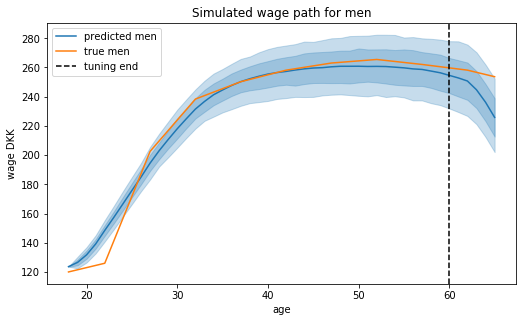

In [235]:
old_sol2 = old_sol.copy()
old_sol2.pop('mse')

women_hours_, _, f = plot_salary_process(**sol_dict, sex='women', sigma_epsilon=0.00001)
men_hours_, _ , f = plot_salary_process(**sol_dict, sex='men', sigma_epsilon=0.00001)

sol_dict2 = sol_dict.copy()
#sol_dict2['delta'] = 0

sp_, _ , f = plot_salary_process(**sol_dict2, sex='men', sigma_epsilon=3)



In [216]:
np.mean(sp_.Z_hist)

0.027589484345270122

In [220]:
scipy.stats.skew(sp_.Z_hist)

0.038208147724256944

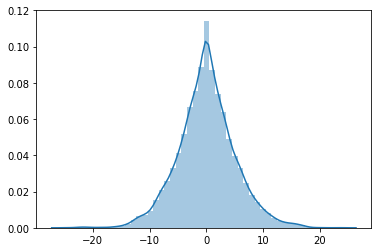

In [223]:
sbn.distplot(sp_.Z_hist)